In [1]:
from __future__ import absolute_import, division, print_function

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.patches import Rectangle
from scipy.io import loadmat

TensorFlow version is  1.13.1


### Load Car Images

In [2]:
train_dir = os.path.join('./data', 'cars_train')
test_dir = os.path.join('./data', 'cars_test')
devkir_dir = os.path.join('./data', 'devkit')

print ('Total training car images:', len(os.listdir(train_dir)))
print ('Total test car images:', len(os.listdir(test_dir)))

Total training car images: 8144
Total test car images: 8041


### Load annotations

In [3]:
cars_meta = loadmat(os.path.join(devkir_dir,'cars_meta.mat'))
cars_train_annos = loadmat(os.path.join(devkir_dir,'cars_train_annos.mat'))
cars_test_annos = loadmat(os.path.join(devkir_dir,'cars_test_annos.mat'))

In [4]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


### Create data frame with annotations & file

In [5]:
def create_df_from_annos(file_dir, annos, columns):
    frame = [[i.flat[0] for i in line] for line in annos['annotations'][0]]
    df = pd.DataFrame(frame, columns=columns)
    df['fname'] = [os.path.join(file_dir, f) for f in df['fname']] #  Appending Path
    return df

In [6]:
train_columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = create_df_from_annos(train_dir, cars_train_annos, train_columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,./data/cars_train/00001.jpg
1,36,116,868,587,2,./data/cars_train/00002.jpg
2,85,109,601,381,90,./data/cars_train/00003.jpg
3,621,393,1484,1096,133,./data/cars_train/00004.jpg
4,14,36,133,99,105,./data/cars_train/00005.jpg


In [7]:
test_columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = create_df_from_annos(test_dir, cars_test_annos, test_columns)
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,./data/cars_test/00001.jpg
1,100,19,576,203,./data/cars_test/00002.jpg
2,51,105,968,659,./data/cars_test/00003.jpg
3,67,84,581,407,./data/cars_test/00004.jpg
4,140,151,593,339,./data/cars_test/00005.jpg


### Merge bounding boxes with class name

In [8]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,./data/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,./data/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,./data/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,./data/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,./data/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


## Display Image

In [9]:
# Returns (Image, title, rectangle patch) for drawing
def get_assets(df, i):
    is_train = df is df_train
    folder = train_dir if is_train else test_dir
    image = Image.open(df['fname'][i])
    title = df['labels'][i] if is_train else 'Unclassified'

    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

# Display image from dataframe
def display_image(df, i):
    image, title, rect = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

In [10]:
freq_labels = df_train.groupby('labels').count()[['class']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
print('total labels: ' + str(len(freq_labels)))
freq_labels.head()

total labels: 196


,count
labels,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47


In [11]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title, rect = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
        im, title, rect = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
    plt.show()

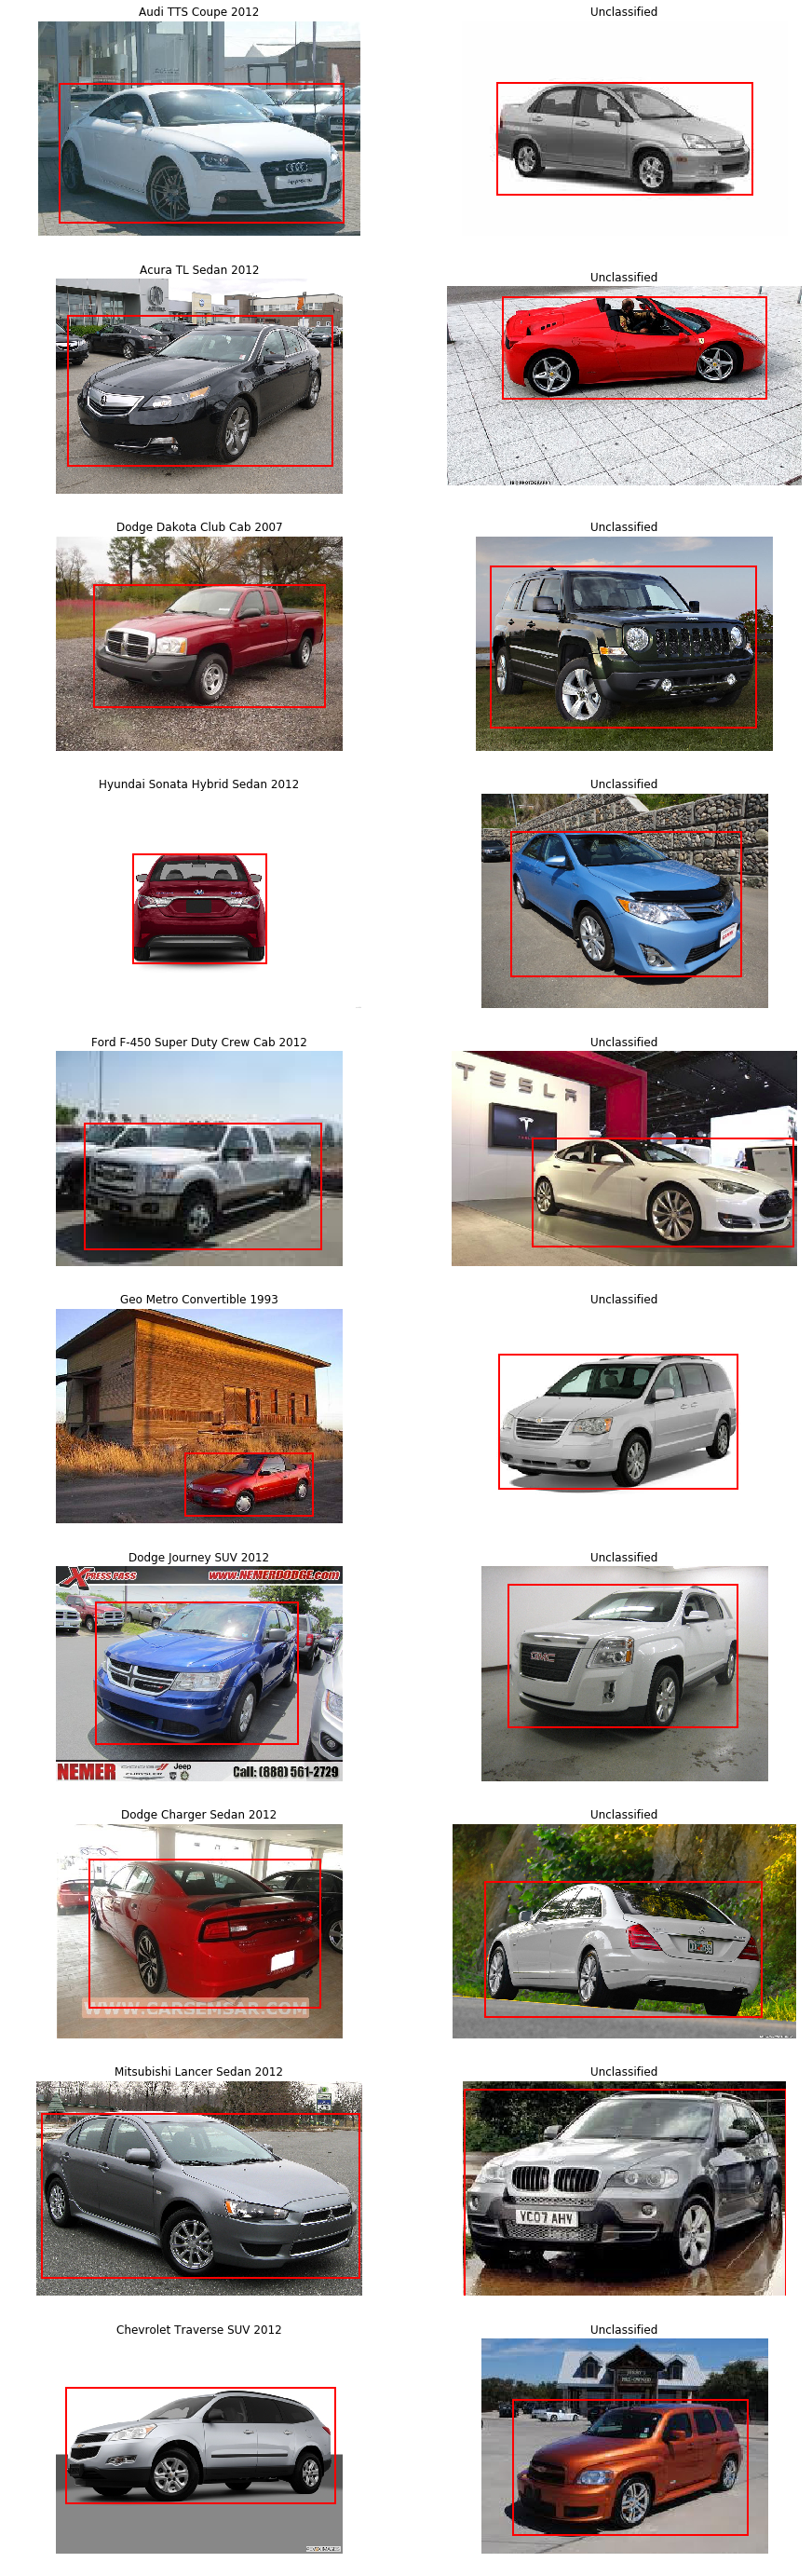

In [12]:
display_range(10)